In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
import os
import seaborn as sns
import tensorflow as tf
import scipy
import glob
import sklearn 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Activation, Dense, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner import BayesianOptimization, HyperParameters

2024-05-27 14:21:03.713160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 14:21:03.713200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 14:21:03.713233: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 14:21:03.721305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 14:21:05.035827: W tensorflow/compiler/tf2t

In [2]:
# Data for the first round of clustering
folder_name_1 = 'AE_Training_1'
file_name_1 = '21_Latent_Space'

# Location to save and load data for round 2 of clustering
# folder_name_2 = 'AE_Training_2'
# if not os.path.exists(folder_name_2):
#     os.makedirs(folder_name_2)
# file_name_2 = ''

# Location of differently trained AE's for round 2 of clustering
# folder_name_3 = ''
# folder_name_4 = ''
# folder_name_5 = ''

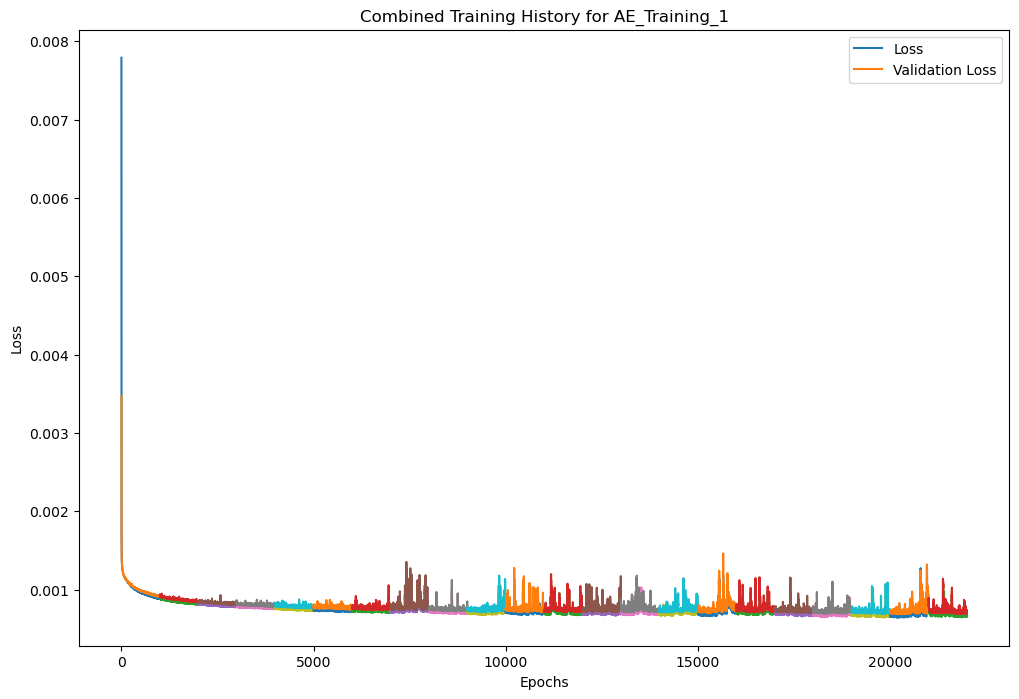

<Figure size 640x480 with 0 Axes>

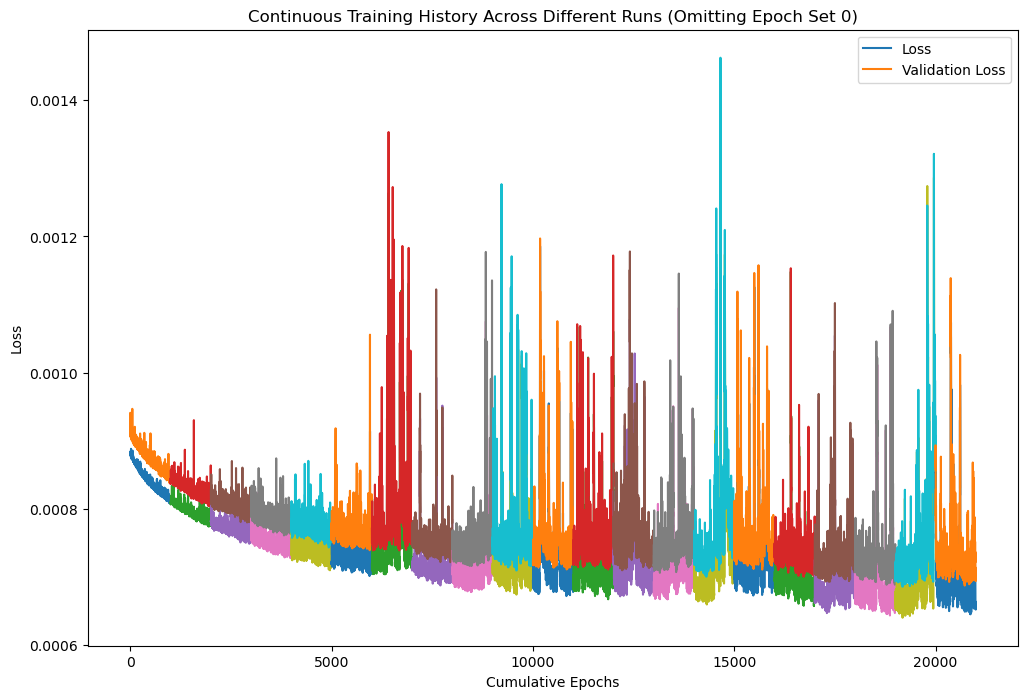

Minimum Loss: 0.0006 at Epoch 19181
Minimum Validation Loss: 0.0007 at Epoch 19181


<Figure size 640x480 with 0 Axes>

In [5]:
name = '_Autoencoder_Training_History' 

# Create a figure for plotting
plt.figure(figsize=(12, 8))

cumulative_epochs_1 = 0  # Variable to track the total number of epochs plotted

for count in range(22):  # 20 because range is exclusive on the upper bound
    file_name = os.path.join(folder_name_1, str(count) + name)
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_1 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_1 = range(cumulative_epochs_1, cumulative_epochs_1 + num_epochs_1)
        
        # Add labels only for the first epoch set
        if count == 0:
            loss_label = 'Loss'
            val_loss_label = 'Validation Loss'
        else:
            loss_label = None
            val_loss_label = None

        # Plot the training history with the adjusted epoch range
        plt.plot(epoch_range_1, training_history['loss'], label=loss_label)
        plt.plot(epoch_range_1, training_history['val_loss'], label=val_loss_label)

        # Update the cumulative number of epochs
        cumulative_epochs_1 += num_epochs_1

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add labels
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Combined Training History for {folder_name_1}')

plt.show()

# Save the combined plot
# plt.savefig(os.path.join(folder_name_1, 'Combined_Training_History.png'), dpi=300)
plt.clf()  

# Figure 2: No Epoch Set 0

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Initialize variables to track the minimum loss and validation loss
min_loss = float('inf')
min_val_loss = float('inf')
min_loss_epoch = None
min_val_loss_epoch = None
cumulative_epochs_2 = 0

for count in range(1, 22):  # Starting from 1 to omit epoch set 0
    file_name = os.path.join(folder_name_1, str(count) + name)
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_2 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_2 = range(cumulative_epochs_2, cumulative_epochs_2 + num_epochs_2)

        # Plot the training history
        plt.plot(epoch_range_2, training_history['loss'], label='Loss' if count == 1 else None)
        plt.plot(epoch_range_2, training_history['val_loss'], label='Validation Loss' if count == 1 else None)

        # Check and update minimum loss and validation loss
        local_min_loss = training_history['loss'].min()
        local_min_val_loss = training_history['val_loss'].min()
        local_min_loss_epoch = training_history['loss'].idxmin()
        local_min_val_loss_epoch = training_history['val_loss'].idxmin()

        if local_min_loss < min_loss:
            min_loss = local_min_loss
            min_loss_epoch = local_min_loss_epoch + cumulative_epochs_2
        if local_min_val_loss < min_val_loss:
            min_val_loss = local_min_val_loss
            min_val_loss_epoch = local_min_val_loss_epoch + cumulative_epochs_2

        # Update the cumulative number of epochs
        cumulative_epochs_2 += num_epochs_2

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add legend and labels
plt.legend()
plt.xlabel('Cumulative Epochs')
plt.ylabel('Loss')
plt.title('Continuous Training History Across Different Runs (Omitting Epoch Set 0)')

# Display the figure
plt.show()

# Optionally save the figure
# plt.savefig(os.path.join(folder_name_1, 'Continuous_Training_History_No_ES_0.png'), dpi=300)
plt.clf()  

# Print the minimum loss and validation loss with corresponding epochs
print(f"Minimum Loss: {min_loss:.4f} at Epoch {min_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at Epoch {min_val_loss_epoch}")

## Clustering

In [7]:
# read in and plot the original data set
latent = pd.read_pickle(f'{folder_name_1}/20_Latent_Space')
latent = latent.replace({'trajectory-0.0': '0', 'trajectory-1.0': '1'}).infer_objects()

In [8]:
# Set the 'index' column as the new index
latent.set_index('index', inplace=True)

# Remove the name of the new index
latent.index.name = None

In [9]:
print(latent)

              x         y  z
11480 -7.586531  0.567537  0
69241 -7.923385  0.059725  1
23321 -5.473639 -1.834530  0
79963 -1.314996  0.128874  1
53139 -7.460699 -2.068390  1
...         ...       ... ..
54086 -6.610475 -1.813323  1
58314 -3.577525 -0.962358  1
16642 -2.664897 -3.951708  0
10766 -6.024659 -2.030483  0
11205 -7.369310  0.902473  0

[16000 rows x 3 columns]


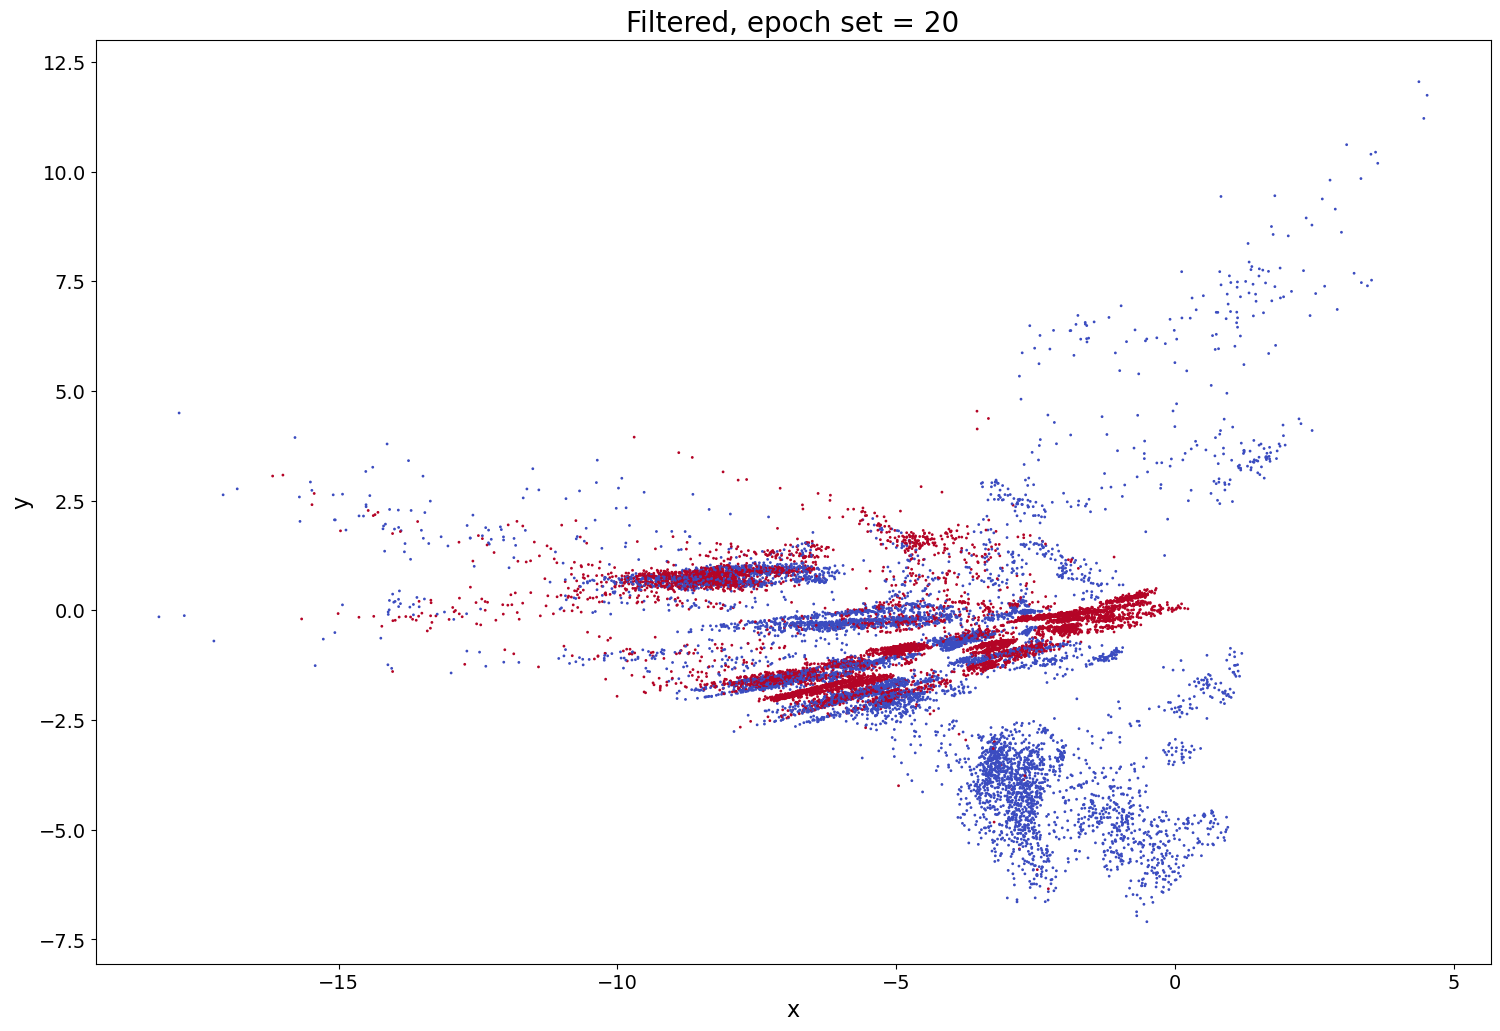

In [11]:
latent['z'] = pd.to_numeric(latent['z'], errors='coerce')

plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 20', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

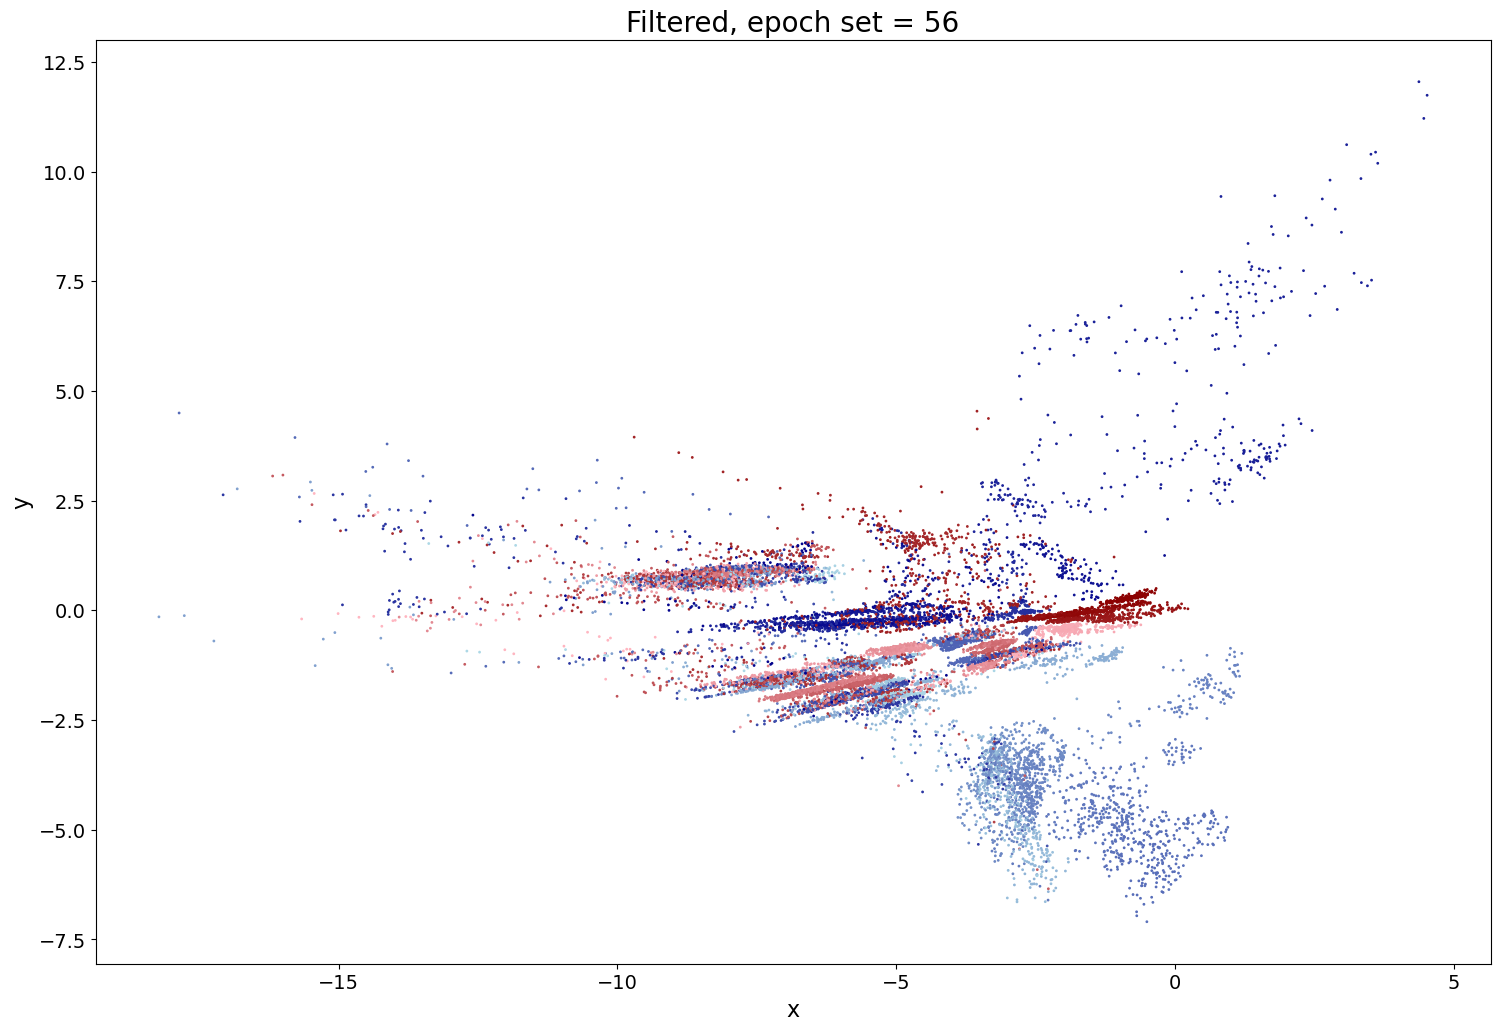

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# Convert the index to a Series and rank the indices
ranked_indices = pd.Series(latent.index).rank(method='dense').astype(int) - 1
normalized_ranks = ranked_indices / ranked_indices.max()

# Create two colormaps: one for blue shades and one for red shades
blue_cmap = LinearSegmentedColormap.from_list("blue_shades", ["lightblue", "darkblue"], N=40000)
red_cmap = LinearSegmentedColormap.from_list("red_shades", ["lightpink", "darkred"], N=40000)

# Function to apply the correct color based on normalized rank
def apply_colormap(norm_rank):
    if norm_rank < 0.5:
        return blue_cmap(norm_rank * 2)  # Normalize rank to 0-1 range for blue
    else:
        return red_cmap((norm_rank - 0.5) * 2)  # Normalize rank to 0-1 range for red

# Apply the colormap to each point based on its normalized rank
colors = [apply_colormap(nr) for nr in normalized_ranks]

plt.figure(figsize=(18, 12))
plt.scatter(latent['x'], latent['y'], c=colors, s=1, alpha=1)
plt.title('Filtered, epoch set = 56', fontsize=20)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("color_coded_data.png", dpi=300)

plt.show()

In [13]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z'], axis = 1)

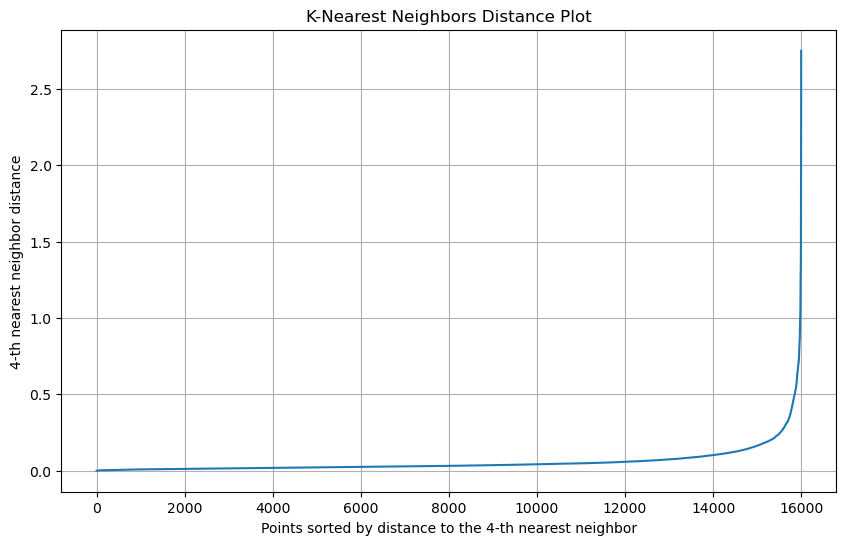

In [14]:
def plot_knn_distances(latent_n, k=4):
    """
    Plot the k-nearest neighbors distance for each point in the dataset to help
    determine a good 'eps' value for DBSCAN.

    Parameters:
    - data: The dataset (as a numpy array or similar).
    - k: The number of neighbors to consider (typically the same as 'min_samples' in DBSCAN).
    """
    # Compute the nearest neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(latent_n)
    distances, _ = nn.kneighbors(latent_n)

    # Sort and plot the distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the {}-th nearest neighbor'.format(k))
    plt.ylabel('{}-th nearest neighbor distance'.format(k))
    plt.title('K-Nearest Neighbors Distance Plot')
    plt.grid(True)
    plt.show()

# Then call the function with your data
# plot_knn_distances(df55.values, k=4) 


plot_knn_distances(latent.values, k=4)  # Adjust 'k' as needed

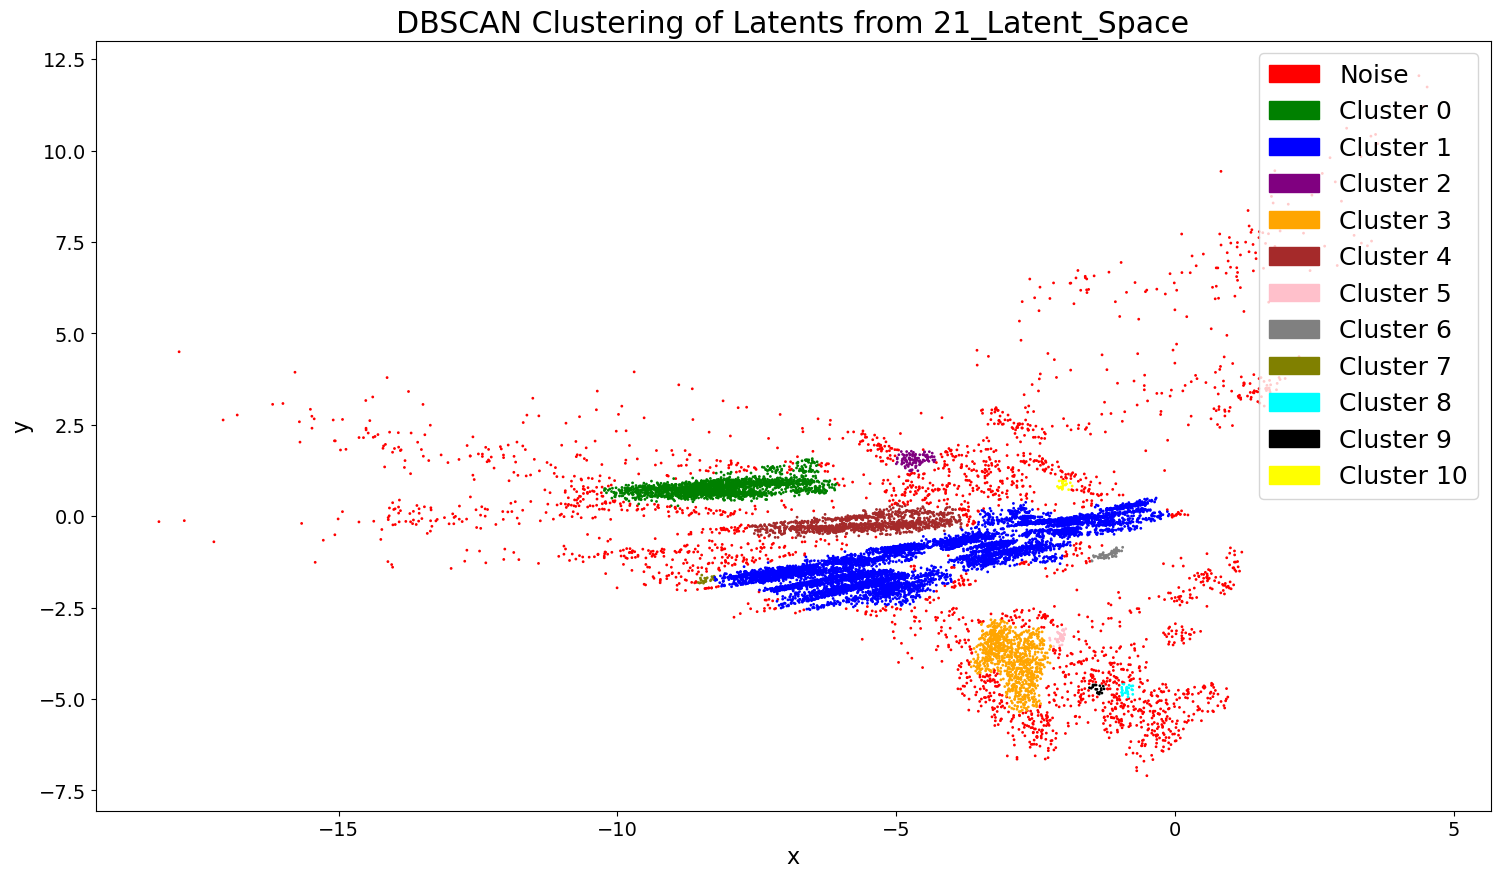

Number of clusters: 11


In [15]:
y_pred = DBSCAN(eps=0.15, min_samples=20).fit_predict(latent_n)

plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))

# Define a custom color palette
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'yellow', 'magenta', 'maroon', 'navy']

# Creating a mapping for cluster labels to colors
unique_labels = np.unique(y_pred)
label_color_map = {lbl: colors[i] for i, lbl in enumerate(unique_labels)}

# Map y_pred to the defined colors
cluster_colors = [label_color_map[label] for label in y_pred]

# Scatter plot using the custom colors
plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=cluster_colors, s=1)

# Creating a legend
legend_handles = [mpatches.Patch(color=label_color_map[lbl], label=f'Cluster {lbl}' if lbl != -1 else 'Noise') for lbl in unique_labels]

plt.legend(handles=legend_handles, loc='upper right')

# Setting labels, titles, and ticks
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'DBSCAN Clustering of Latents from {file_name_1}')
# png_path = os.path.join(folder_name_2, f'{file_name_1}_Original_Cluster_All.png')
# plt.savefig(png_path, dpi=300)
plt.show()

# Print the number of clusters
print('Number of clusters: {}'.format(len(unique_labels[unique_labels != -1])))

In [16]:
# latent_n is DataFrame after removing the 'z' column
# latent is the original DataFrame with the 'z' column

# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred
latent['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

    cluster  z  count
0        -1  0   1965
1        -1  1    583
2         0  0    925
3         0  1   1319
4         1  0   3148
5         1  1   5734
6         2  0     15
7         2  1     93
8         3  0    908
9         3  1      6
10        4  0    873
11        4  1    251
12        5  0     37
13        6  0     53
14        7  0      9
15        7  1     14
16        8  0     26
17        9  0     20
18       10  0     21


/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


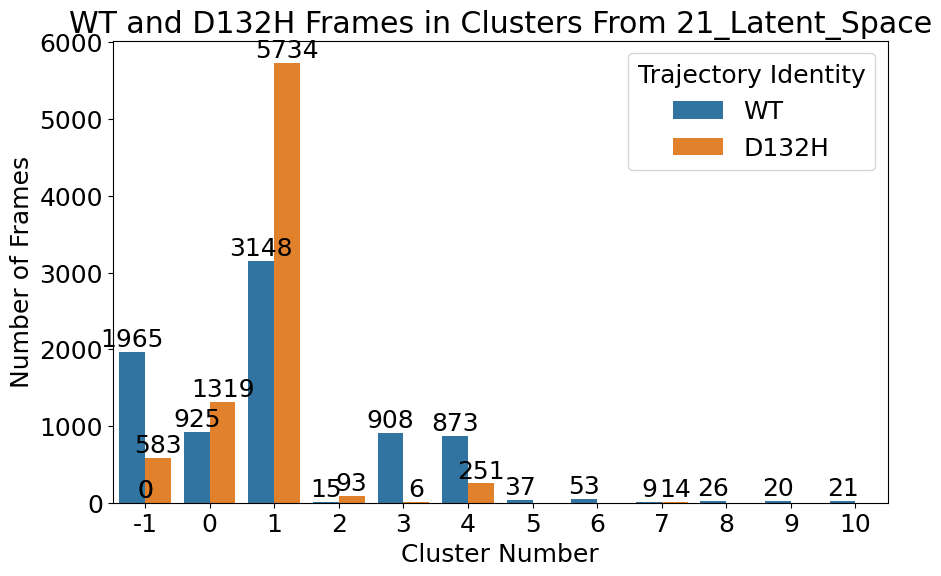

In [17]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title(f'WT and D132H Frames in Clusters From {file_name_1}')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()

In [18]:
# Create a dictionary to hold the indices for each cluster
cluster_indices = {}

# Loop through each unique cluster label
for cluster_label in np.unique(y_pred):
    # Extract indices of the datapoints belonging to the current cluster
    indices = latent_n[latent_n['cluster'] == cluster_label].index.tolist()
    # Store these indices in the dictionary
    cluster_indices[cluster_label] = indices

# Print the summary of indices for each cluster
for cluster_label, indices in cluster_indices.items():
    print(f"Cluster {cluster_label}: {len(indices)} datapoints")
    print(f"Indices: {indices}\n")

Cluster -1: 2548 datapoints
Indices: [69241, 53139, 15851, 20042, 33015, 20409, 70316, 32961, 13687, 60117, 28680, 18091, 32134, 4537, 18455, 33373, 61365, 17408, 30139, 20291, 36889, 36099, 19048, 36307, 63021, 60040, 33844, 18907, 20231, 33134, 10075, 1530, 32411, 24534, 25682, 18281, 19831, 70771, 34151, 19152, 17267, 70041, 18187, 38709, 60155, 32518, 39602, 34512, 13364, 60110, 39086, 73484, 18771, 4260, 32806, 73505, 18901, 32215, 19511, 5545, 36588, 70960, 805, 71935, 10194, 38344, 34060, 70525, 20450, 73324, 71842, 15725, 71828, 18749, 33012, 30302, 32309, 17315, 30350, 70998, 71944, 32257, 4127, 5743, 36302, 33956, 20404, 18204, 34250, 17698, 19966, 37529, 19843, 1473, 20387, 10156, 12324, 33602, 61445, 14741, 9949, 17920, 5301, 34443, 16085, 33727, 32931, 34044, 4121, 60109, 37605, 68018, 16045, 10064, 72657, 36019, 70689, 5922, 33815, 73463, 36578, 38703, 71283, 36292, 30355, 18581, 40034, 15641, 50163, 5199, 17295, 14654, 40176, 14237, 15816, 36515, 57900, 30259, 19195, 183